# About this Dataset

## Context

This dataset and the solution is an amended version of a document found on Kaggle.

### Problem Statement

Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

## Content

### Attributes

#### People

- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if the customer complained in the last 2 years, 0 otherwise

#### Products

- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

#### Promotion

- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

#### Place

- NumWebPurchases: Number of purchases made through the company’s website
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s website in the last month

### Target

Need to perform clustering to summarize customer segments.

### Acknowledgement

The dataset for this project is provided by Dr. Omar Romero-Hernandez.



### 1 Importeren libraries
- Voer onderstaande cel uit om de benodigde libraries te importeren.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.manifold import TSNE

### 2 Inlezen en aanpassen van de dataset
- Voer onderstaande cel uit en vorm een beeld van de dataset.
- Er wordt hieronder ook o.a. feature engineering toegepast. 
- Beschrijf in comments wat er wordt gedaan en wat de resultaten hiervan zijn.

In [2]:
df = pd.read_csv('marketing_campaign.csv', sep = '\t', parse_dates = ['Dt_Customer'], infer_datetime_format=True, dayfirst = True)
df = df.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(df))

#Feature Engineering
#Age of customer today 
df["Age"] = 2022-df["Year_Birth"]

#Total spendings on various items
df["Spent"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

#Deriving living situation by marital status"Alone"
df["Living_With"]=df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
df["Children"]=df["Kidhome"]+df["Teenhome"]

#Feature for total members in the householde
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner":2})+ df["Children"]

#Feature pertaining parenthood
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)

#Segmenting education levels in five groups
df["Education"]=df["Education"].replace({"Basic":1,"2n Cycle":2, "Graduation":3,"Master":4, "PhD":5})

#For clarity
df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(to_drop, axis=1)

#Dropping the outliers by setting a cap on Age and income. 
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(df))

# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
df = df.drop(cols_del, axis=1)

#Label Encoding the object dtypes.
LE=LabelEncoder()

df['Living_With']=df[['Living_With']].apply(LE.fit_transform) 
print("All features are now numerical")

The total number of data-points after removing the rows with missing values are: 2216
The total number of data-points after removing the outliers are: 2212
All features are now numerical


In [3]:
display(df.info(), df.describe(), df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2212 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   int64  
 1   Income               2212 non-null   float64
 2   Kidhome              2212 non-null   int64  
 3   Teenhome             2212 non-null   int64  
 4   Recency              2212 non-null   int64  
 5   Wines                2212 non-null   int64  
 6   Fruits               2212 non-null   int64  
 7   Meat                 2212 non-null   int64  
 8   Fish                 2212 non-null   int64  
 9   Sweets               2212 non-null   int64  
 10  Gold                 2212 non-null   int64  
 11  NumDealsPurchases    2212 non-null   int64  
 12  NumWebPurchases      2212 non-null   int64  
 13  NumCatalogPurchases  2212 non-null   int64  
 14  NumStorePurchases    2212 non-null   int64  
 15  NumWebVisitsMonth    2212 non-null   i

None

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent
count,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,...,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000
mean,3.460669,51958.810579,0.441682,0.505877,49.019439,305.287523,26.329566,167.029837,37.648734,27.046564,...,4.088156,2.672242,5.806510,5.321429,53.086347,607.268083,0.645570,0.947559,2.593128,0.714286
std,1.004193,21527.278844,0.536955,0.544253,28.943121,337.322940,39.744052,224.254493,54.772033,41.090991,...,2.742187,2.927542,3.250939,2.425597,11.701599,602.513364,0.478449,0.749466,0.906236,0.451856
min,1.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,26.000000,5.000000,0.000000,0.000000,1.000000,0.000000
25%,3.000000,35233.500000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,...,2.000000,0.000000,3.000000,3.000000,45.000000,69.000000,0.000000,0.000000,2.000000,0.000000
50%,3.000000,51371.000000,0.000000,0.000000,49.000000,175.500000,8.000000,68.000000,12.000000,8.000000,...,4.000000,2.000000,5.000000,6.000000,52.000000,397.000000,1.000000,1.000000,3.000000,1.000000
75%,4.000000,68487.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,...,6.000000,4.000000,8.000000,7.000000,63.000000,1048.000000,1.000000,1.000000,3.000000,1.000000
max,5.000000,162397.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,...,27.000000,28.000000,13.000000,20.000000,82.000000,2525.000000,1.000000,3.000000,5.000000,1.000000


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,3,58138.0,0,0,58,635,88,546,172,88,...,8,10,4,7,65,1617,0,0,1,0
1,3,46344.0,1,1,38,11,1,6,2,1,...,1,1,2,5,68,27,0,2,3,1
2,3,71613.0,0,0,26,426,49,127,111,21,...,8,2,10,4,57,776,1,0,2,0
3,3,26646.0,1,0,26,11,4,20,10,3,...,2,0,4,6,38,53,1,1,3,1
4,5,58293.0,1,0,94,173,43,118,46,27,...,5,3,6,5,41,422,1,1,3,1


## Standaardiseer de data
We gaan op deze dataset clustering toepassen. Het is daarom aan te bevelen (zo niet noodzakelijk) om de data te standaardiseren.
- stanaardiseer de dataset
- Als je standadiseert, wordt voor iedere waarde de zogenaamde z-score berekend. Beschrijf wat de z-score is. Hoe wordt deze berekend?
- Waarom is normaliseren noodzakelijk als je gaat clusteren?

In [9]:
#Creating a copy of data
ds = df.copy()

#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")
display(df.head(), scaled_ds.head())

All features are now scaled


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,3,58138.0,0,0,58,635,88,546,172,88,...,8,10,4,7,65,1617,0,0,1,0
1,3,46344.0,1,1,38,11,1,6,2,1,...,1,1,2,5,68,27,0,2,3,1
2,3,71613.0,0,0,26,426,49,127,111,21,...,8,2,10,4,57,776,1,0,2,0
3,3,26646.0,1,0,26,11,4,20,10,3,...,2,0,4,6,38,53,1,1,3,1
4,5,58293.0,1,0,94,173,43,118,46,27,...,5,3,6,5,41,422,1,1,3,1


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.458850,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,1.426865,2.503607,-0.555814,0.692181,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.458850,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-1.126420,-0.571340,-1.171160,-0.132545,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.458850,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,1.426865,-0.229679,1.290224,-0.544908,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.458850,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.761665,-0.913000,-0.555814,0.279818,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,1.533251,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.332600,0.111982,0.059532,-0.132545,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


In [7]:
ds1 = df.copy()
for col in ds1.columns:    
    ds1[col] = (ds1[col] - ds1[col].mean())/ds1[col].std(ddof=0)
ds1

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.458850,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,1.426865,2.503607,-0.555814,0.692181,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.458850,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-1.126420,-0.571340,-1.171160,-0.132545,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.458850,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,1.426865,-0.229679,1.290224,-0.544908,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.458850,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.761665,-0.913000,-0.555814,0.279818,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,1.533251,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.332600,0.111982,0.059532,-0.132545,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,-0.458850,0.430444,-0.822754,0.908097,-0.104347,1.197084,0.419540,0.066770,0.079461,2.213965,...,1.791619,0.111982,-0.555814,-0.132545,0.163575,1.218061,0.740959,0.069987,0.449070,0.632456
2236,1.533251,0.560123,2.902796,0.908097,0.241237,0.298631,-0.662628,-0.611184,-0.687527,-0.658360,...,1.426865,-0.229679,-0.248141,0.692181,1.958607,-0.271040,0.740959,2.739158,2.656499,0.632456
2237,-0.458850,0.233347,-0.822754,-0.929699,1.450778,1.787156,0.545373,0.222878,-0.103155,-0.366260,...,-0.761665,0.111982,2.213242,0.279818,-1.033114,1.052052,-1.349603,-1.264598,-1.758359,-1.581139
2238,0.537201,0.803172,-0.822754,0.908097,-1.417564,0.363866,0.092373,0.209498,0.773403,0.071892,...,0.697355,0.795303,1.290224,-0.957271,1.103830,0.391336,0.740959,0.069987,0.449070,0.632456


## Bepaal het beste aantal clusters
- Maak een lijndiagram waarin je de 'inertia' bepaalt van k-means clustering voor de waardes van k van 1 t/m 10.
- Wat is de beste waarde van k?

C:\Users\ejvdham\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ejvdham\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ejvdham\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ejvdham\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ejvdham\Anaconda3\lib\site-packages\skl

[48664.000000000015,
 34442.96987497788,
 29939.51301924705,
 27526.634353266214,
 26131.33031874595,
 25161.808629663,
 24025.28486537256,
 23138.993269868944,
 22522.46510361418,
 21889.545811758566]

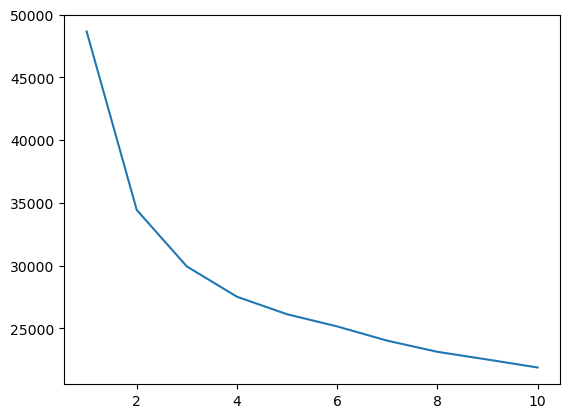

In [10]:
inertia = []
for k in range(1,11):
    model = KMeans(n_clusters=k)
    model.fit(scaled_ds)
    inertia.append(model.inertia_)
display(inertia)
plt.plot(range(1,11), inertia)
plt.show()

## Cluster en wijs de clusters toe aan de dataset
- Voer de K-mean clustering uit en wijs de verkregen clusternummers toe aan de dataset. Maak hiervoor een nieuwe kolom met daarin de clusternummers.

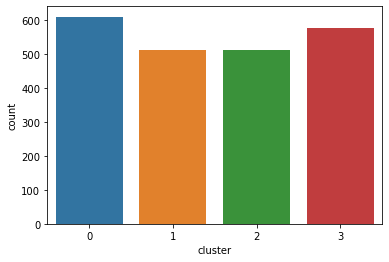

In [11]:
model = KMeans(n_clusters= 4)
labels = model.fit_predict(scaled_ds)
df['cluster'] = labels

sns.countplot(data = df, x=df['cluster'])
plt.show()



### Visualiseer met t-SNE
- Pas t-SNE toe om de clusters te visualiseren.

C:\Users\hoier\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


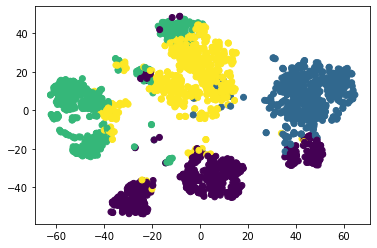

2212 2212


In [14]:
model = TSNE(learning_rate=50)
transformed = model.fit_transform(scaled_ds)
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs, ys, c=labels)
plt.show()
print(len(transformed), len(labels))

## Bepaal het beste aantal dimensies voor PCA
- We gaan nu Principal Component Analysis toepassen op de dataset.
- Maak een staafdiagram waarin je de "explained variance" per component laat zien.
- Hoeveel "Principal" components zijn er?

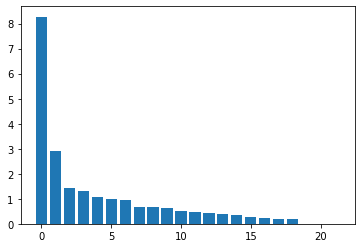

In [15]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_ds)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ )
plt.show()


## Pas PCA toe
- Maak een nieuw dataframe met daarin het gekozen aantal principal components.

In [16]:
pca = PCA(n_components=2)
pca.fit(scaled_ds)
transformed = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2"]))
transformed.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-5.340313e-17,2.876718,-5.903104,-2.547135,-0.786313,2.416588,7.436229
col2,2212.0,2.419202e-17,1.711089,-4.488566,-1.318328,-0.120621,1.245388,6.313089


## Cluster met PCA data
- Pas nu nogmaals k-means clustering toe maar nu met het dataframe met de principal components.

In [17]:
model = KMeans(n_clusters=4)
labels = model.fit_predict(transformed)

df['cluster_pca'] = labels

## Onderzoek of er verschillen zijn tussen oorspronkelijke cluster en PCA clusters

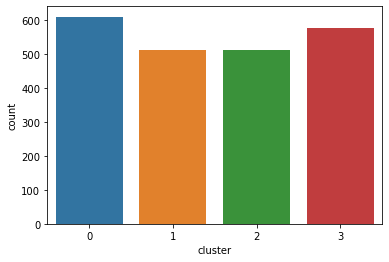

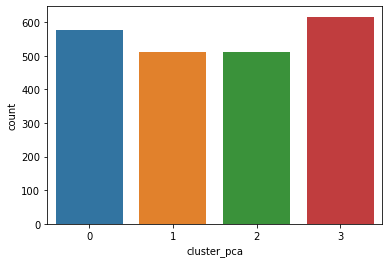

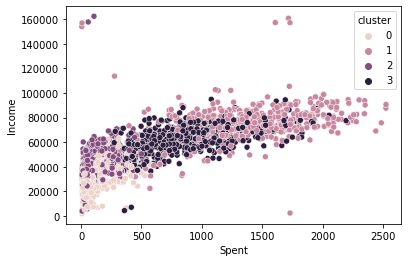

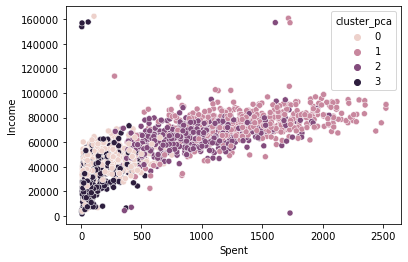

In [18]:
sns.countplot(data = df, x=df['cluster'])
plt.show()
sns.countplot(data = df, x=df['cluster_pca'])
plt.show()
sns.scatterplot(data = df, x = df['Spent'], y = df['Income'], hue = df['cluster'])
plt.show()
sns.scatterplot(data = df, x = df['Spent'], y = df['Income'], hue = df['cluster_pca'])
plt.show()
## waarschijnlijk alleen andere clusternummers

## Visualiseer en beschrijf het profiel van de klanten in ieder cluster
- Gebruik de clustering met alle variabelen om een profiel op te stellen van de klanten in ieder cluster.

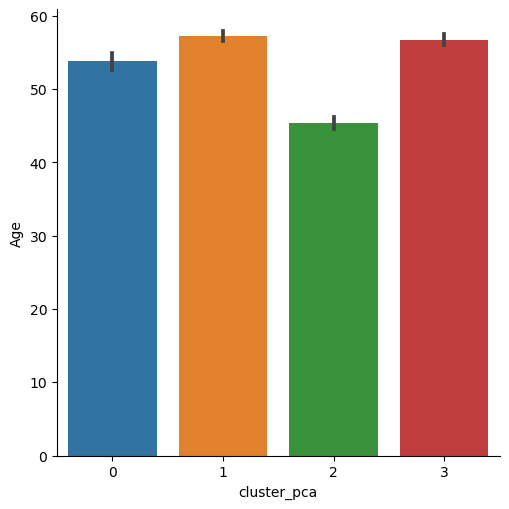

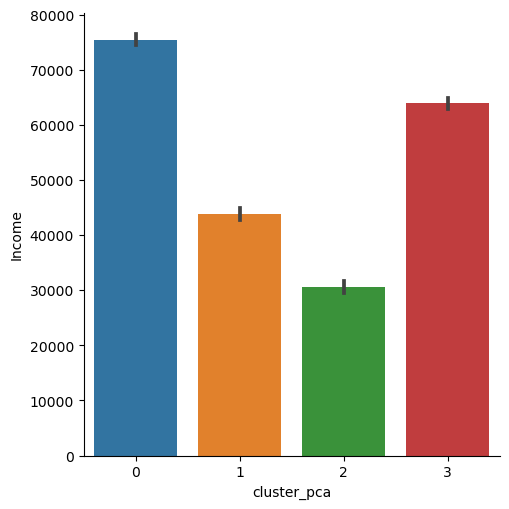

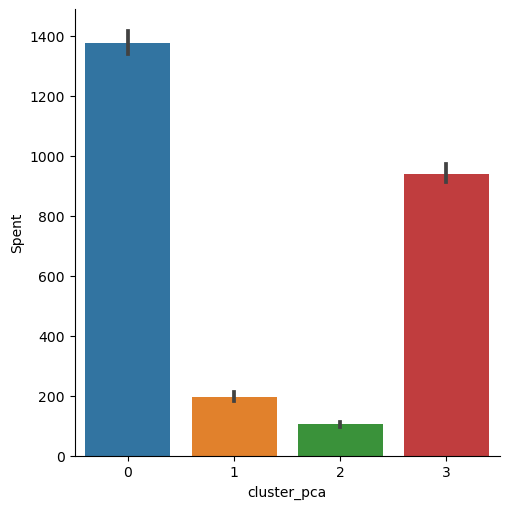

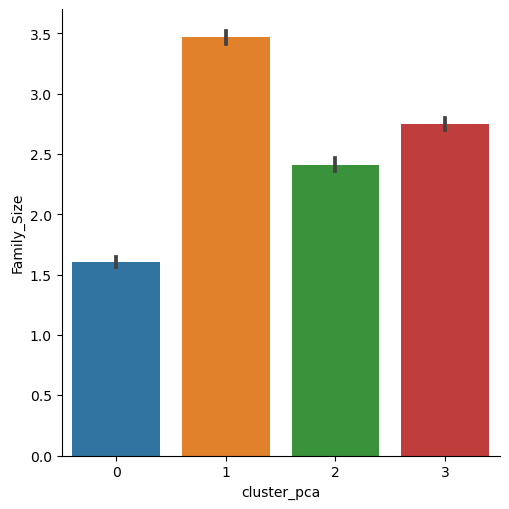

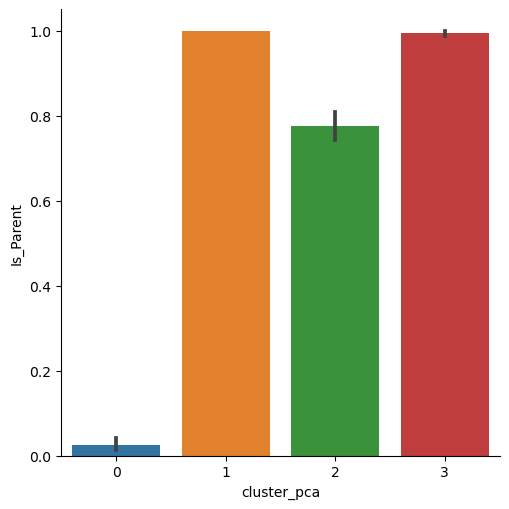

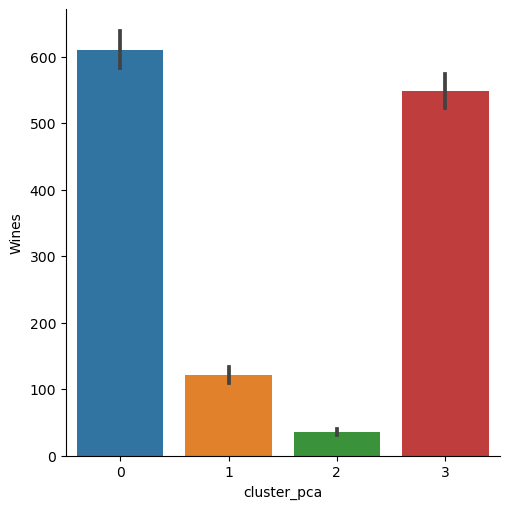

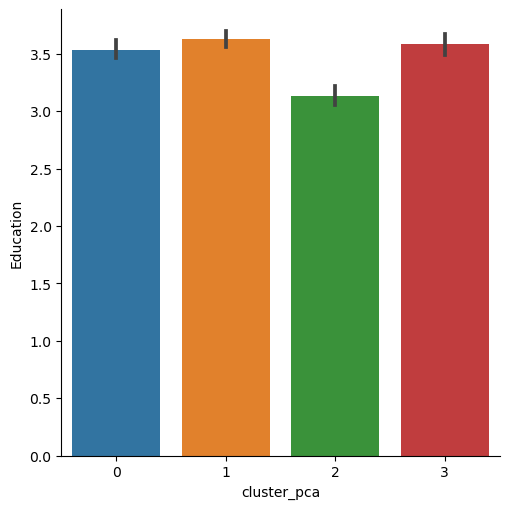

In [229]:
for col in ['Age','Income', 'Spent', 'Family_Size', 'Is_Parent', 'Wines', 'Education']:
    sns.catplot(data = df, x = 'cluster_pca', y = col , kind = 'bar')
    plt.show()
#cluster 0: startende gezinnen: jong, laag inkomen, weinig uitgaven, meestal ouder(s), kleine gezinnen (0 of 1 kind), hoog opgeleid
#cluster 1: vermogende alleenstaand of alleen partner: gemiddelde leeftijd, hoog inkomen, geeft zeer veel uit, alleenstaand of alleen partner, geen kinderen, geeft geld uit aan luxe, hoog opgeleid
#cluster 2: gezinnen met hoog inkomen: gemiddeld/oud, middenhoog inkomen, geeft veel uit, kleine gezinnen, meestal ouder van minimaal 1 kind, koopt luxe, hoogst opgeleid
#cluster 3: gezinnen met laag inkomen: gemiddeld/oud, laag inkomen, geeft weinig uit, grote gezinnen, geeft weinig uit aan luxe, laagst opgeleid

C:\Users\ejvdham\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


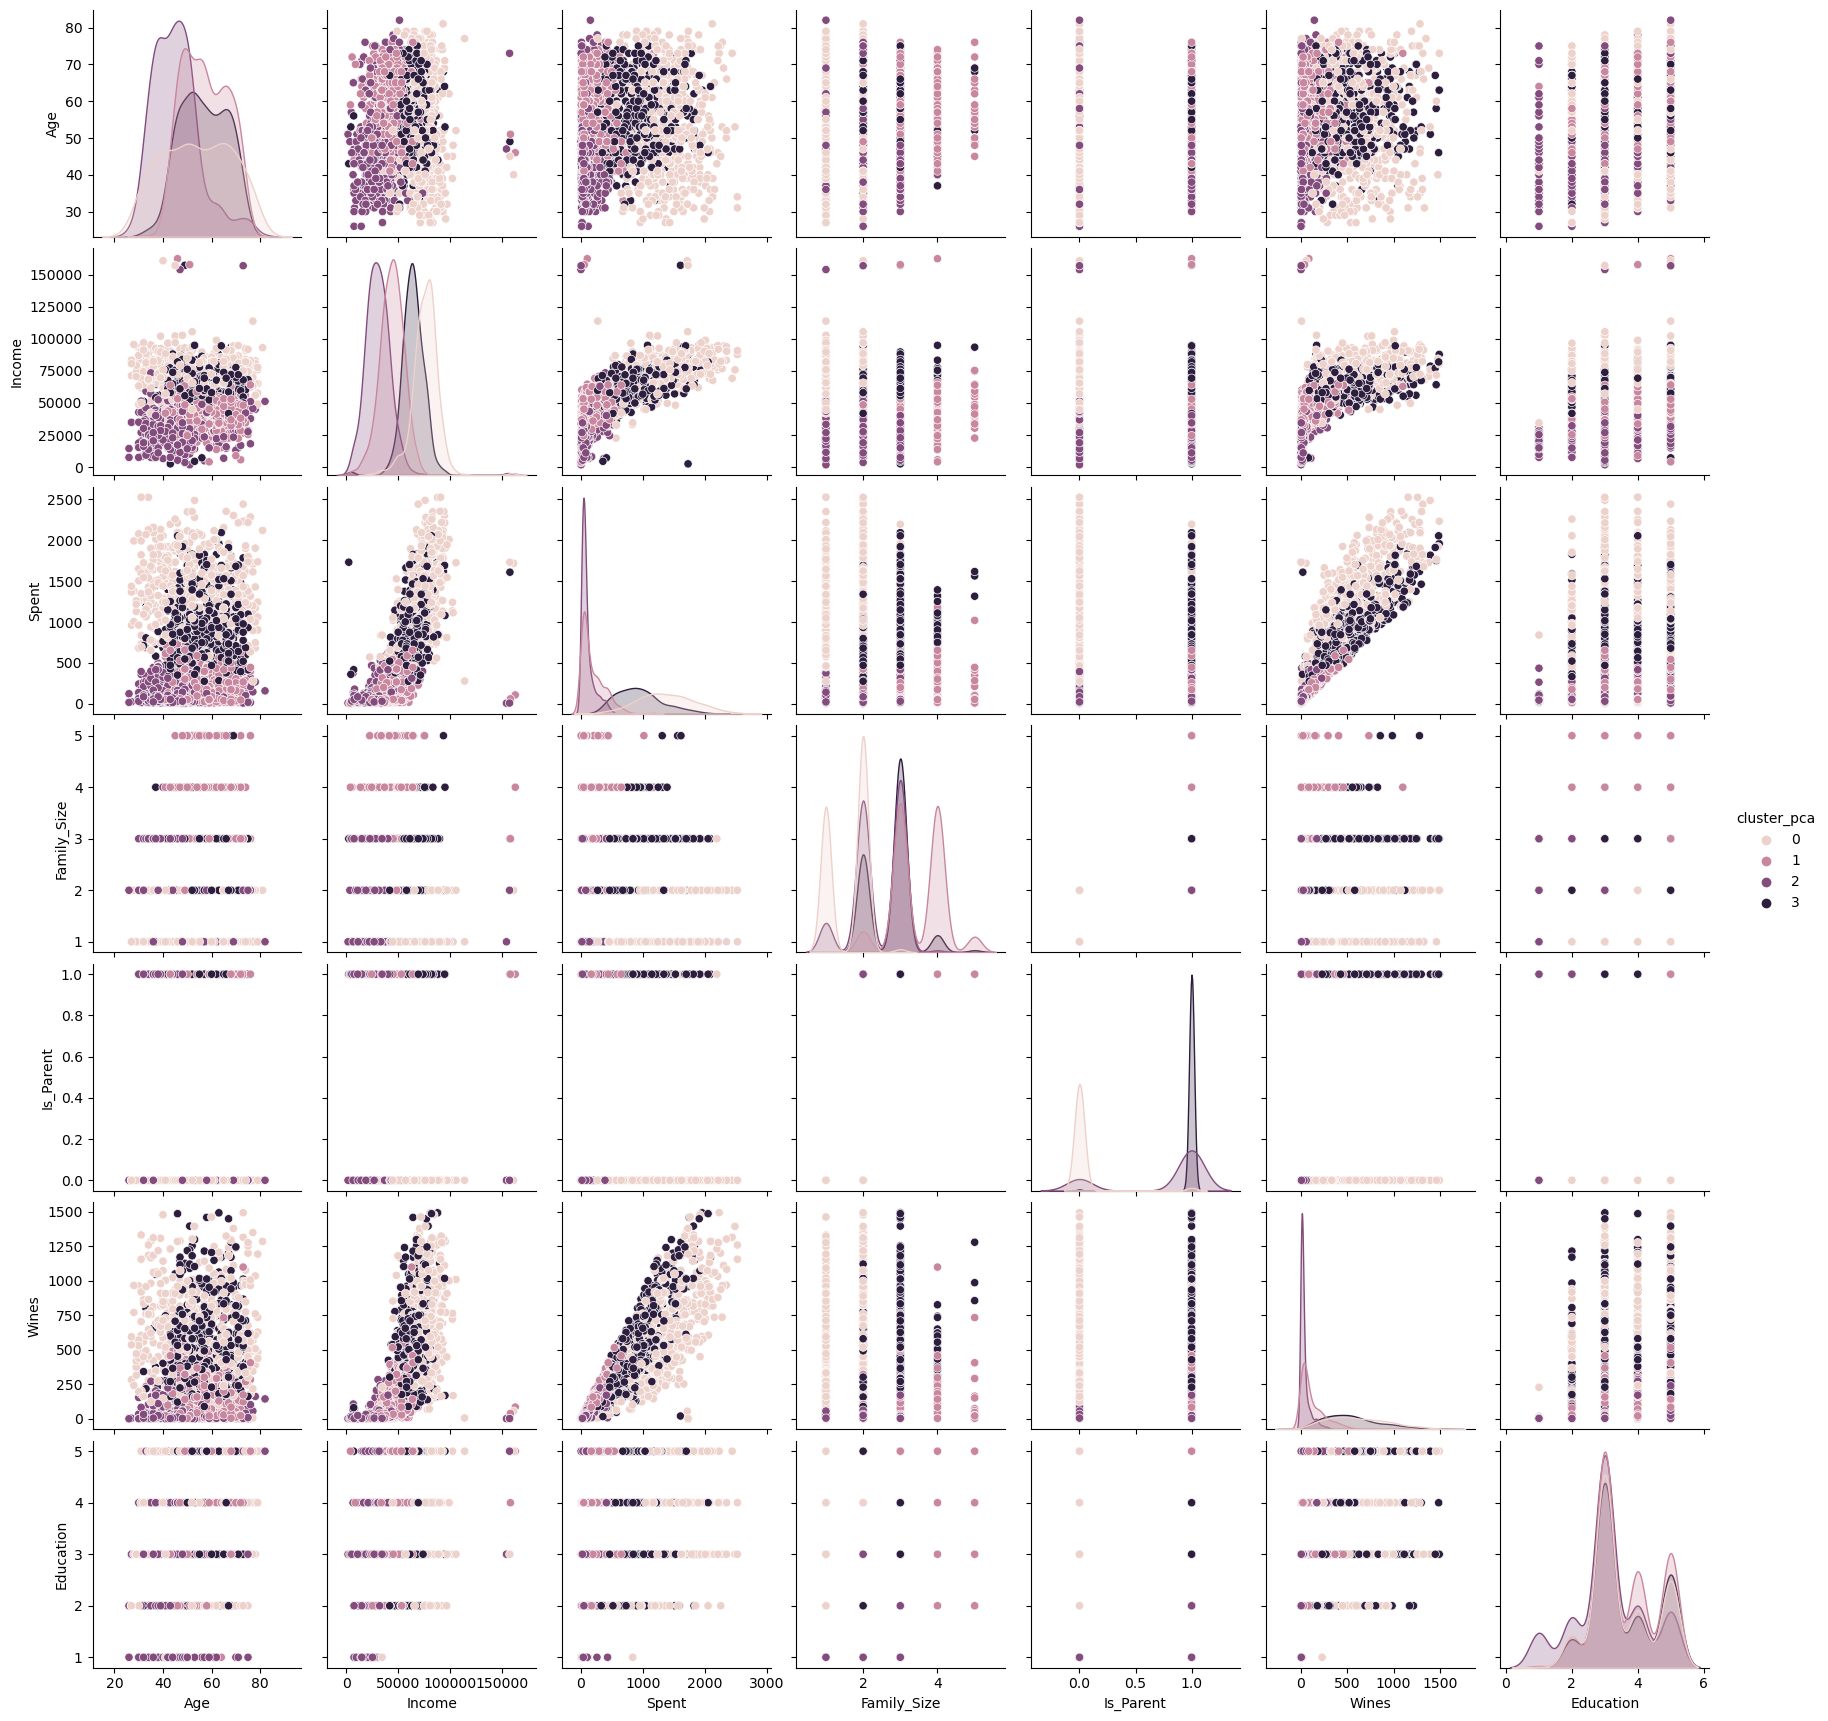

In [231]:
sns.pairplot(data = df[['Age','Income', 'Spent', 'Family_Size', 'Is_Parent', 'Wines','cluster_pca', 'Education']], hue = 'cluster_pca')

plt.show()